In [1]:
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
%matplotlib inline

In [2]:
# physical constants in MKS and Kelvin units unless specified otherwise
kB = 1.38064852e-23
c = 2.99792458e8 #m/s
h = 6.62607004e-34
TCMB = 2.726 #JCH (Rahul was using 2.732, not sure why)

In [3]:
# CMB blackbody (derivative) SED
def nu_be_CMB(nu):
    '''
    Input:
    nu = frequency [GHz]
    Output:
    CMB blackbody derivative SED in specific intensity units per K (W/m^2/Hz/sr/K)
    '''
    x = h*nu*1.e9/kB/TCMB
    return 2.*(kB*TCMB)**3. / (h*c)**2. * np.exp(x) * x**4. / (np.exp(x) - 1)**2. / TCMB #JCH: include prefactor

In [4]:
# tSZ SED
def nu_be_SZ(nu):
    '''
    Input:
    nu = frequency [GHz]
    Output
    tSZ SED in specific intensity units per K (W/m^2/Hz/sr/K)
    '''
    x = h*nu*1.e9/kB/TCMB
    return nu_be_CMB(nu) * (x * 1./np.tanh(x/2.) - 4.) #JCH: fix this (Rahul was missing the nu_be_CMB factor)

In [5]:
# modified blackbody (MBB) SED
def nu_be_MBB(nu, beta, T_dust = 9.6):
    '''
    Input:
    nu = frequency [GHz]
    beta = MBB spectral index
    T_dust = MBB temperature [K], default 9.6 K matches the likelihood code
    Output:
    MBB SED in specific intensity units (W/m^2/Hz/sr) WITH ARBITRARY OVERALL NORMALIZATION
    '''
    nu_arb = 100. #arbitrary reference frequency
    return (nu/nu_arb)**beta * 2*h*(nu*1.e9)**3./c**2. / (np.exp(h*nu*1.e9/kB/T_dust) - 1.)

In [6]:
# power-law in specific intensity units
def nu_be_PL(nu, beta):
    '''
    Input:
    nu = frequency [GHz]
    beta = power-law spectral index
    Output:
    power-law SED in specific intensity units (W/m^2/Hz/sr) WITH ARBITRARY OVERALL NORMALIZATION
    '''
    nu_arb = 100. #arbitrary reference frequency
    return (nu/nu_arb)**beta

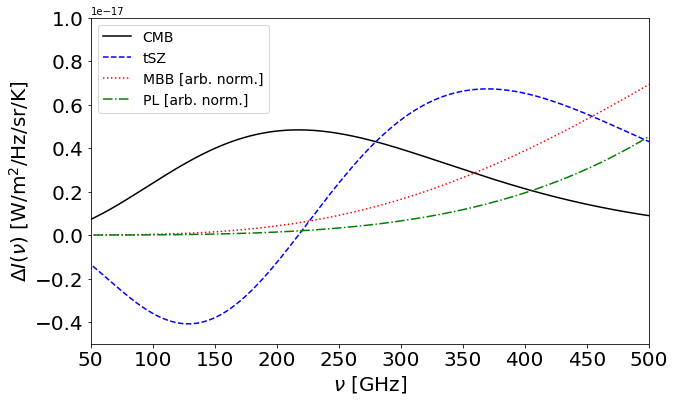

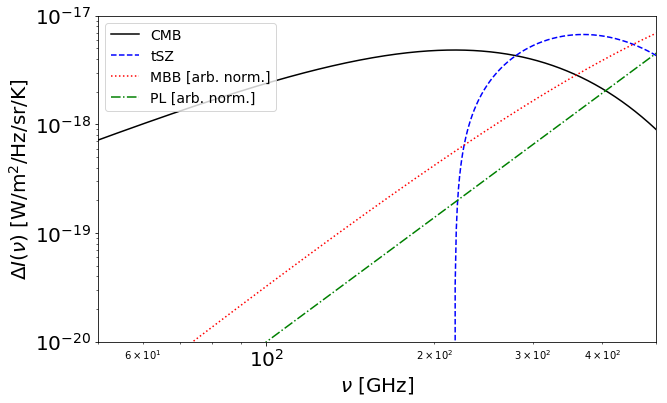

In [7]:
# test plot
nu_test = (np.linspace(1.,1000.,num=1000))
nu_be_CMB_test = nu_be_CMB(nu_test)
nu_be_SZ_test = nu_be_SZ(nu_test)
nu_be_MBB_test = nu_be_MBB(nu_test, 2.1)
nu_be_PL_test = nu_be_PL(nu_test, 3.8)

# linear axes
plt.figure(figsize=(10,6))
plt.plot(nu_test, nu_be_CMB_test, color='k', label='CMB')
plt.plot(nu_test, nu_be_SZ_test, color='b', label='tSZ', ls='--')
plt.plot(nu_test, nu_be_MBB_test/700., color='r', label='MBB [arb. norm.]', ls=':')
plt.plot(nu_test, nu_be_PL_test/1e20, color='g', label='PL [arb. norm.]', ls='-.')
plt.tick_params(labelsize=20) 
plt.xlim(50.,500.)
plt.ylim(-0.5e-17,1.e-17)
plt.xlabel(r'$\nu$ [GHz]', fontsize=20)
plt.ylabel(r'$\Delta I(\nu)$ [W/m${}^2$/Hz/sr/K]', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
plt.show()

# log axes
plt.figure(figsize=(10,6))
plt.plot(nu_test, nu_be_CMB_test, color='k', label='CMB')
plt.plot(nu_test, nu_be_SZ_test, color='b', label='tSZ', ls='--')
plt.plot(nu_test, nu_be_MBB_test/700., color='r', label='MBB [arb. norm.]', ls=':')
plt.plot(nu_test, nu_be_PL_test/1e20, color='g', label='PL [arb. norm.]', ls='-.')
plt.tick_params(labelsize=20) 
plt.xlim(50.,500.)
plt.ylim(1.e-20,1.e-17)
plt.xlabel(r'$\nu$ [GHz]', fontsize=20)
plt.ylabel(r'$\Delta I(\nu)$ [W/m${}^2$/Hz/sr/K]', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [8]:
# power-law SEDs
# match the likelihood code assumptions
be_s = -1.0 #Galactic synchrotron (alpha_gs in ACTPol_DR2.f90)
be_radio = -0.5  #radio Poisson sources (alpha_s in ACTPol_DR2.f90)
#be_ff = -0.1 #free-free #not used in the likelihood
be_d = 3.8 # "Galactic dust" (beta_g in ACTPol_DR2.f90)
#be_RJ = 2.0 #R-J #not used in the likelihood

# MBB SEDs
# match the likelihood code assumptions
# this is actually a free parameter in the likelihood, just approx via the Dunkley+2013 best-fit result
be_CIB = 2.1 # "CIB" (beta_c in ACTPol_DR2.f90)

In [15]:
# read in ACTPol PA1/2/3 bandpass data
# these are the truncated/cleaned bandpasses produced in truncate_bandpasses.ipynb
# also include the PA3 bandpasses with "blue leak" appended (as extracted from PA6 data)
N_ACTPol = 6 #PA1, PA2, PA3_90, PA3_150, PA3_90_BL, PA3_150_BL
files_ACTPol = ['PA1_avg_passband_wErr_trunc_20200220.txt','PA2_avg_passband_wErr_trunc_20200220.txt','PA3_avg_passband_90_wErr_trunc_20200220.txt','PA3_avg_passband_150_wErr_trunc_20200220.txt','PA3_avg_passband_90_wErr_trunc_PA6_90_BL_added_20200220.txt','PA3_avg_passband_150_wErr_trunc_PA6_150_BL_added_20200220.txt']
nu_ACTPol = []
fnu_ACTPol = []
fnu_err_ACTPol = []

for i in range(N_ACTPol):
    nu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,0])
    fnu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,1])
    if (i < 4):
        fnu_err_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,2])

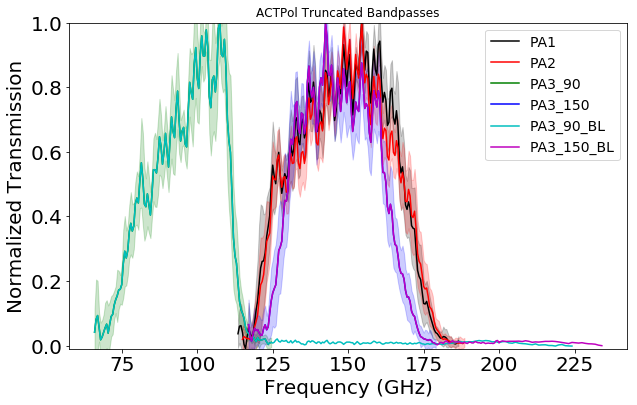

In [16]:
# plot to double check everything is OK
# plot truncated bandpasses
colors = ['k','r','g','b','c','m']
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(4):
    plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1', 'PA2', 'PA3_90', 'PA3_150', 'PA3_90_BL', 'PA3_150_BL'], fontsize=14)
plt.title("ACTPol Truncated Bandpasses")
plt.show()

In [17]:
# Effective central frequency to diffuse sources -- note that compact sources differ!
# This uses the "weighted centroid" approach of Lyman
def central_freq(nu, fnu, SED_choice):
    '''
    Input:
    nu = frequencies at which bandpass is measured [GHz]
    fnu = bandpass transmission measurements [dimensionless]
    SED_choice = one of {CMB, tSZ, CIB, dust, radio, synch}
    Output:
    effective central frequency [GHz]
    '''
    assert(SED_choice is not None)
    if (SED_choice == 'CMB'):
        snu = nu_be_CMB(nu)
    elif (SED_choice == 'tSZ'):
        snu = nu_be_SZ(nu)
    elif (SED_choice == 'CIB'):
        snu = nu_be_MBB(nu, be_CIB, 9.6)
    elif (SED_choice == 'dust'):
        snu = nu_be_PL(nu, be_d)
    elif (SED_choice == 'radio'):
        snu = nu_be_PL(nu, be_radio)
    elif (SED_choice == 'synch'):
        snu = nu_be_PL(nu, be_s)
    elif (SED_choice == 'flat'):
        snu = nu_be_PL(nu, 0.)
    else:
        print("unknown SED")
        return -np.inf
    # evaluate integral
    nu_cent = np.trapz(nu * fnu * snu, x=nu) / np.trapz(fnu * snu, x=nu)
    return nu_cent
    

In [18]:
# evaluate central frequency for CMB responses, as these cannot be computed via Hasselfield effective freq.
# note that these are NOT USED in the likelihood
for i in range(N_ACTPol):
    print('-------------')
    print(files_ACTPol[i])
    print("CMB:", central_freq(nu_ACTPol[i],fnu_ACTPol[i], 'CMB'))
    # compare to power-law with alpha=0
    print("flat:", central_freq(nu_ACTPol[i],fnu_ACTPol[i], 'flat'))

-------------
PA1_avg_passband_wErr_trunc_20200220.txt
CMB: 149.57289191141743
flat: 148.23515927144632
-------------
PA2_avg_passband_wErr_trunc_20200220.txt
CMB: 149.9440500863093
flat: 148.62576888062924
-------------
PA3_avg_passband_90_wErr_trunc_20200220.txt
CMB: 97.91625977599362
flat: 95.99448668962779
-------------
PA3_avg_passband_150_wErr_trunc_20200220.txt
CMB: 147.61697414092288
flat: 146.70911185423373
-------------
PA3_avg_passband_90_wErr_trunc_PA6_90_BL_added_20200220.txt
CMB: 102.00214818114522
flat: 98.17819541008201
-------------
PA3_avg_passband_150_wErr_trunc_PA6_150_BL_added_20200220.txt
CMB: 148.91803137602903
flat: 147.7835053127677


In [19]:
# Effective frequency to diffuse sources -- note that compact sources differ!
# This uses the Hasselfield Eq. 15 approach
# The effective frequency is defined as the solution nu0 of the equation
# 1/S(nu0) \int d\nu S(\nu) f(\nu) = 1/D_CMB(nu0) \int d\nu D_CMB(\nu) f(\nu)
# where S(\nu) is the SED of the component of interest
# and f(\nu) is the bandpass transmission
N_search = 400000
def eff_freq(nu, fnu, SED_choice):
    '''
    Input:
    nu = frequencies at which bandpass is measured [GHz]
    fnu = bandpass transmission measurements [dimensionless]
    SED_choice = one of {CMB, tSZ, CIB, dust, radio, synch}
    Output:
    effective frequency [GHz]
    '''
    assert(SED_choice is not None)
    # compute LHS of Eq. 15 on a grid
    # move the ratio of the nu0-related things to the LHS
    nu0_arr = np.linspace(np.min(nu),np.max(nu),num=N_search)
    snu0_CMB = nu_be_CMB(nu0_arr)
    LHS_numerator = snu0_CMB
    if (SED_choice == 'CMB'):
        #snu = nu_be_CMB(nu)
        print("eff. freq. undefined for CMB")
        return -np.inf
    elif (SED_choice == 'tSZ'):
        snu = nu_be_SZ(nu)
        snu0_arr = nu_be_SZ(nu0_arr)
    elif (SED_choice == 'CIB'):
        snu = nu_be_MBB(nu, be_CIB, 9.6)
        snu0_arr = nu_be_MBB(nu0_arr, be_CIB, 9.6)
    elif (SED_choice == 'dust'):
        snu = nu_be_PL(nu, be_d)
        snu0_arr = nu_be_PL(nu0_arr, be_d)
    elif (SED_choice == 'radio'):
        snu = nu_be_PL(nu, be_radio)
        snu0_arr = nu_be_PL(nu0_arr, be_radio)
    elif (SED_choice == 'synch'):
        snu = nu_be_PL(nu, be_s)
        snu0_arr = nu_be_PL(nu0_arr, be_s)
    elif (SED_choice == 'flat'):
        snu = nu_be_PL(nu, 0.)
        snu0_arr = nu_be_PL(nu0_arr, 0.)
    else:
        print("unknown SED")
        return -np.inf
    # evaluate integrals
    # RHS of Eq. 15, moving the ratio of the two integrals to the RHS
    RHS_numerator = np.trapz(fnu * nu_be_CMB(nu), x=nu)
    RHS_denominator = np.trapz(fnu * snu, x=nu)
    RHS = RHS_numerator / RHS_denominator
    # LHS of Eq. 15, with the ratio of the nu0-related things
    LHS_denominator = snu0_arr
    LHS_arr = LHS_numerator / LHS_denominator
    # solve Eq. 15
    ind_min = np.argmin(np.absolute(LHS_arr - RHS))
    nu_eff = nu0_arr[ind_min]
    return nu_eff


In [20]:
# evaluate effective frequencies
N_comps = 5
comps = ['tSZ','CIB','dust','radio','synch']
for i in range(N_ACTPol):
    print('-------------')
    print(files_ACTPol[i])
    for j in range(N_comps):
        print(comps[j], eff_freq(nu_ACTPol[i],fnu_ACTPol[i], comps[j]))


-------------
PA1_avg_passband_wErr_trunc_20200220.txt
tSZ 149.9960397650994
CIB 151.0292157980395
dust 151.1963633159083
radio 147.03501053752635
synch 146.90016117540293
-------------
PA2_avg_passband_wErr_trunc_20200220.txt
tSZ 150.36560228900572
CIB 151.41081642704106
dust 151.58057875144686
radio 147.42066690166723
synch 147.29114045285112
-------------
PA3_avg_passband_90_wErr_trunc_20200220.txt
tSZ 98.37933722334306
CIB 98.77450571126428
dust 98.82174457936145
radio 95.7586769216923
synch 95.47407371018427
-------------
PA3_avg_passband_150_wErr_trunc_20200220.txt
tSZ 147.90882959707398
CIB 148.61520741301854
dust 148.7303541258853
radio 145.92297498243744
synch 145.83200443001107
-------------
PA3_avg_passband_90_wErr_trunc_PA6_90_BL_added_20200220.txt
tSZ 103.47718331795829
CIB 106.51428081070202
dust 107.12936914842287
radio 97.3757125642814
synch 96.97724916812291
-------------
PA3_avg_passband_150_wErr_trunc_PA6_150_BL_added_20200220.txt
tSZ 149.34276083190207
CIB 150.66995